In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
from torchvision import datasets, transforms
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
import copy
import sys, time
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from torch.autograd import Variable
import os
import pickle

In [ ]:
import os
os.chdir("/content/drive/MyDrive/SkinDisease_Project")

In [ ]:
pwd

'/content/drive/MyDrive/SkinDisease_Project'

In [ ]:
!pip install pickle-mixin

  Preparing metadata (setup.py) ... done
  Created wheel for pickle-mixin: filename=pickle_mixin-1.0.2-py3-none-any.whl size=5990 sha256=b6f811f5fde353b1ee30fda0c082ecb8e66f53876984d6f8d964d131c3ecf94b
  Stored in directory: /root/.cache/pip/wheels/3e/c6/e9/d1b0a34e1efc6c3ec9c086623972c6de6317faddb2af0a619c
Successfully built pickle-mixin


In [ ]:
# 데이터 증강 정의
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizing the images to 224x224 for ResNet50
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ResNet50 normalization
])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ImageFolder를 사용하여 데이터셋 로딩
train_dataset = datasets.ImageFolder(root = './Data/train', transform=train_transform)
test_dataset = datasets.ImageFolder(root = './Data/test', transform=transform)

# DataLoader를 사용하여 배치 단위로 데이터 로딩
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
print(test_dataset.classes)

['Acne', 'Psoriasis', 'Rosacea', 'vitiligo']


In [ ]:
# ResNet50 모델 불러오기
model = models.resnet50(pretrained=True)

# 출력층을 데이터셋 클래스 수에 맞게 수정
model.fc = torch.nn.Linear(model.fc.in_features, len(train_dataset.classes))  # 클래스 수에 맞게 변경

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 117MB/s]


In [ ]:
# 손실 함수 정의
criterion = torch.nn.CrossEntropyLoss()

# 옵티마이저 정의
optimizer = optim.Adam(filter(lambda p : p.requires_grad, model.parameters()), lr=0.001)

# # 모델을 GPU로 이동 (가능한 경우)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())  # 가장 좋은 모델의 가중치 저장
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()  # 학습 모드로 설정
        running_loss = 0.0
        corrects = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # 기울기 초기화
            optimizer.zero_grad()

            # 순전파
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # 역전파 및 최적화
            loss.backward()
            optimizer.step()

            # 통계 기록
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = corrects.double() / total

        print(f"Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}")

        # 모델의 정확도가 이전보다 더 좋으면 모델 업데이트
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    # 가장 좋은 모델 가중치 로드
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
#학습 진행
model = train_model(model, train_loader, criterion, optimizer, num_epochs=10)

Epoch 1/10 | Loss: 0.7374 | Accuracy: 0.7088
Epoch 2/10 | Loss: 0.5409 | Accuracy: 0.8004
Epoch 3/10 | Loss: 0.4649 | Accuracy: 0.8260
Epoch 4/10 | Loss: 0.4104 | Accuracy: 0.8466
Epoch 5/10 | Loss: 0.3720 | Accuracy: 0.8640
Epoch 6/10 | Loss: 0.3014 | Accuracy: 0.8915
Epoch 7/10 | Loss: 0.2665 | Accuracy: 0.8965
Epoch 8/10 | Loss: 0.2742 | Accuracy: 0.8938
Epoch 9/10 | Loss: 0.2514 | Accuracy: 0.9011
Epoch 10/10 | Loss: 0.1950 | Accuracy: 0.9263


In [ ]:
#모델 저장(클래스 이름도 포함)
torch.save({'model_state_dict' : model.state_dict(),
           'class_names' : test_dataset.classes}, './Resnet50_pytorch/ResNet50_final.pth')

**저장된 모델 다시 불러오기**<br>
vvvvvvvvvvvvvvvvvvvvvvvvv

In [ ]:
# ResNet50 모델 불러오기
model = models.resnet50(pretrained=True)

# 출력층을 데이터셋 클래스 수에 맞게 수정
model.fc = torch.nn.Linear(model.fc.in_features, len(train_dataset.classes))  # 클래스 수에 맞게 변경

# 손실 함수 정의
criterion = torch.nn.CrossEntropyLoss()

# 옵티마이저 정의
optimizer = optim.Adam(filter(lambda p : p.requires_grad, model.parameters()), lr=0.001)

# # 모델을 GPU로 이동 (가능한 경우)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 저장된 state_dict 로드
state_dict = torch.load('./Resnet50_pytorch/ResNet50_final.pth')
print(state_dict['class_names'])
# 모델에 state_dict 적용
model.load_state_dict(state_dict['model_state_dict'])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-18-fdb4d1aa85bc>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more detai

['Acne', 'Psoriasis', 'Rosacea', 'vitiligo']


<All keys matched successfully>

In [ ]:
#추가 학습 진행
model = train_model(model, train_loader, criterion, optimizer, num_epochs=30)

#학습 끝내고 저장하기(클래스 이름도 포함)
torch.save({'model_state_dict' : model.state_dict(),
           'class_names' : test_dataset.classes}, './Resnet50_pytorch/ResNet50_final.pth')

Epoch 1/30 | Loss: 0.3178 | Accuracy: 0.8759
Epoch 2/30 | Loss: 0.2441 | Accuracy: 0.9075
Epoch 3/30 | Loss: 0.1831 | Accuracy: 0.9386
Epoch 4/30 | Loss: 0.2012 | Accuracy: 0.9258
Epoch 5/30 | Loss: 0.1410 | Accuracy: 0.9505
Epoch 6/30 | Loss: 0.1745 | Accuracy: 0.9432
Epoch 7/30 | Loss: 0.1919 | Accuracy: 0.9336
Epoch 8/30 | Loss: 0.1719 | Accuracy: 0.9483
Epoch 9/30 | Loss: 0.1412 | Accuracy: 0.9473
Epoch 10/30 | Loss: 0.1837 | Accuracy: 0.9391
Epoch 11/30 | Loss: 0.1106 | Accuracy: 0.9638
Epoch 12/30 | Loss: 0.0848 | Accuracy: 0.9675
Epoch 13/30 | Loss: 0.0841 | Accuracy: 0.9716
Epoch 14/30 | Loss: 0.1700 | Accuracy: 0.9364
Epoch 15/30 | Loss: 0.1037 | Accuracy: 0.9606
Epoch 16/30 | Loss: 0.0655 | Accuracy: 0.9794
Epoch 17/30 | Loss: 0.0368 | Accuracy: 0.9876
Epoch 18/30 | Loss: 0.0859 | Accuracy: 0.9707
Epoch 19/30 | Loss: 0.1231 | Accuracy: 0.9602
Epoch 20/30 | Loss: 0.1267 | Accuracy: 0.9560
Epoch 21/30 | Loss: 0.1194 | Accuracy: 0.9570
Epoch 22/30 | Loss: 0.1148 | Accuracy: 0.95

In [ ]:
#추가 학습 진행
model = train_model(model, train_loader, criterion, optimizer, num_epochs=20)

#학습 끝내고 저장하기(클래스 이름도 포함)
torch.save({'model_state_dict' : model.state_dict(),
           'class_names' : test_dataset.classes}, './Resnet50_pytorch/ResNet50_final.pth')

Epoch 1/20 | Loss: 0.0314 | Accuracy: 0.9906
Epoch 2/20 | Loss: 0.3099 | Accuracy: 0.8958
Epoch 3/20 | Loss: 0.2496 | Accuracy: 0.9146
Epoch 4/20 | Loss: 0.0866 | Accuracy: 0.9748
Epoch 5/20 | Loss: 0.1754 | Accuracy: 0.9398
Epoch 6/20 | Loss: 0.0780 | Accuracy: 0.9755
Epoch 7/20 | Loss: 0.1308 | Accuracy: 0.9597
Epoch 8/20 | Loss: 0.1088 | Accuracy: 0.9661
Epoch 9/20 | Loss: 0.0683 | Accuracy: 0.9767
Epoch 10/20 | Loss: 0.0776 | Accuracy: 0.9778
Epoch 11/20 | Loss: 0.0908 | Accuracy: 0.9733
Epoch 12/20 | Loss: 0.1718 | Accuracy: 0.9364
Epoch 13/20 | Loss: 0.0756 | Accuracy: 0.9778
Epoch 14/20 | Loss: 0.0513 | Accuracy: 0.9804
Epoch 15/20 | Loss: 0.1464 | Accuracy: 0.9481
Epoch 16/20 | Loss: 0.1846 | Accuracy: 0.9289
Epoch 17/20 | Loss: 0.0632 | Accuracy: 0.9786
Epoch 18/20 | Loss: 0.1426 | Accuracy: 0.9552
Epoch 19/20 | Loss: 0.3960 | Accuracy: 0.8751
Epoch 20/20 | Loss: 0.1839 | Accuracy: 0.9364


In [ ]:
def evaluate_model(model, test_loader, criterion):
    model.eval()  # 평가 모드로 설정
    corrects = 0
    total = 0
    total_loss = 0.0  # 손실값 누적 변수

    with torch.no_grad():  # 평가 시에는 기울기 계산을 하지 않음
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)  # 손실 계산
            total_loss += loss.item() * inputs.size(0)  # 배치 크기로 가중치 적용

            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

    acc = corrects.double() / total
    avg_loss = total_loss / total  # 평균 손실 계산
    print(f"Test Accuracy: {acc:.4f}")
    print(f"Test Loss: {avg_loss:.4f}")

# 모델 평가
evaluate_model(model, test_loader, criterion)

Test Accuracy: 0.7941
Test Loss: 0.9781


Confusion Matrix:
[[62  1  2  0]
 [ 5 81  2  0]
 [ 2  1 25  0]
 [19 20  4 48]]


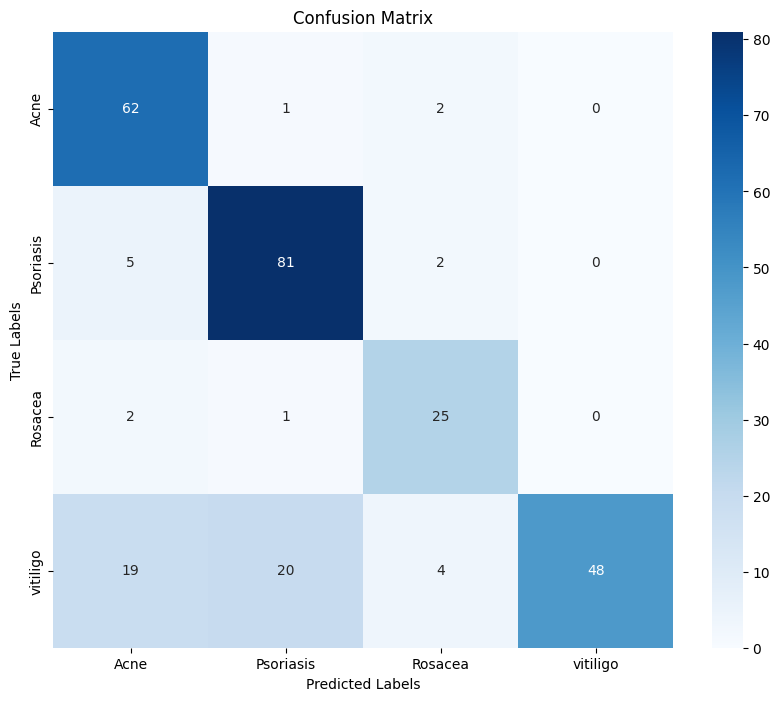

Classification Report:
              precision    recall  f1-score   support

        Acne       0.70      0.95      0.81        65
   Psoriasis       0.79      0.92      0.85        88
     Rosacea       0.76      0.89      0.82        28
    vitiligo       1.00      0.53      0.69        91

    accuracy                           0.79       272
   macro avg       0.81      0.82      0.79       272
weighted avg       0.84      0.79      0.78       272



In [ ]:
# 모델 평가
model.eval()

# 예측값 및 실제값 저장용 리스트 초기화
all_preds, all_labels = [], []

# 모델 추론
with torch.no_grad():
    for inputs, labels in test_loader:
        # 데이터 장치로 이동
        inputs, labels = inputs.to(device), labels.to(device)

        # 모델 예측
        outputs = model(inputs)
        _, preds = torch.max(outputs, dim=1)

        # CPU로 이동 후 numpy 배열로 변환 및 저장
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix 계산 및 출력
cm = confusion_matrix(all_labels, all_preds)
print('Confusion Matrix:')
print(cm)

# Confusion Matrix 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Classification Report 출력
report = classification_report(all_labels, all_preds, target_names=test_dataset.classes)
print('Classification Report:')
print(report)

예측된 질병: Rosacea


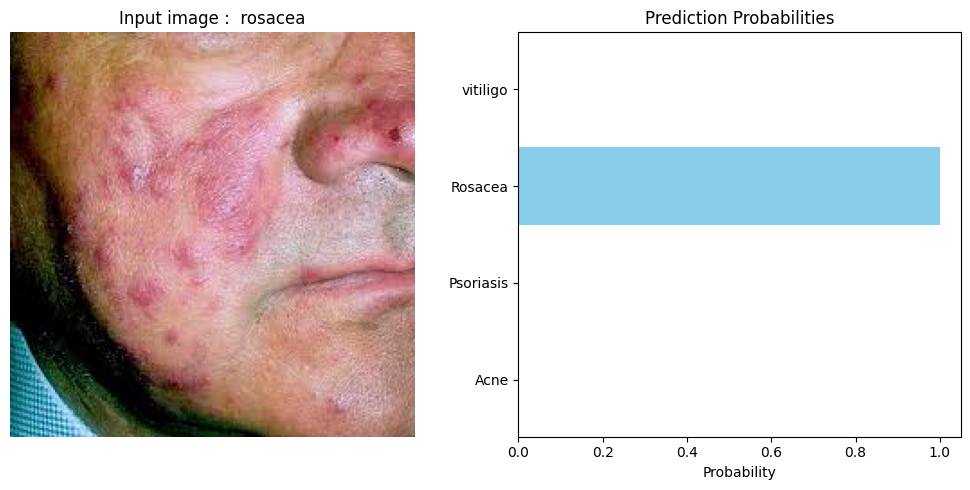

In [ ]:
# 2. 테스트 이미지 불러오기
image_path = "./Resnet50_pytorch/rosacea_test_img2.jpeg"  # 테스트 이미지 경로
image = Image.open(image_path)
image_class_name = 'rosacea'

# 이미지 전처리
input_tensor = transform(image).unsqueeze(0).to(device)

# 3. 예측 수행
output = model(input_tensor)
probabilities = torch.nn.functional.softmax(output[0], dim=0)
class_idx = torch.argmax(probabilities).item()

# 클래스 이름 가져오기
class_names = state_dict['class_names']  # 클래스 이름은 ImageFolder에서 자동으로 불러옴
predicted_class = class_names[class_idx]

# 4. 결과 출력
print(f"예측된 질병: {predicted_class}")

# 5. 시각화
plt.figure(figsize=(10, 5))

# 1) 입력 이미지 시각화
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis("off")
plt.title(f"Input image :  {image_class_name}")

# 2) 클래스별 확률 시각화
plt.subplot(1, 2, 2)
plt.barh(class_names, probabilities.cpu().detach().numpy(), color='skyblue')
plt.xlabel("Probability")
plt.title("Prediction Probabilities")
plt.tight_layout()
plt.show()

예측된 질병: Acne


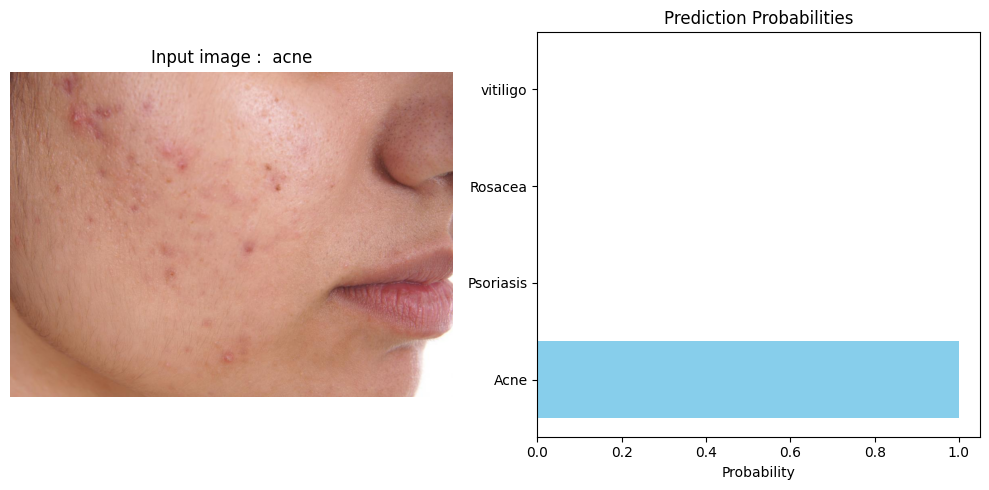

In [ ]:
# 2. 테스트 이미지 불러오기
image_path = "./Resnet50_pytorch/acne_test_img2.jpg"  # 테스트 이미지 경로
image = Image.open(image_path)
image_class_name = 'acne'

# 이미지 전처리
input_tensor = transform(image).unsqueeze(0).to(device)

# 3. 예측 수행
output = model(input_tensor)
probabilities = torch.nn.functional.softmax(output[0], dim=0)
class_idx = torch.argmax(probabilities).item()

# 클래스 이름 가져오기
class_names = state_dict['class_names']  # 클래스 이름은 ImageFolder에서 자동으로 불러옴
predicted_class = class_names[class_idx]

# 4. 결과 출력
print(f"예측된 질병: {predicted_class}")

# 5. 시각화
plt.figure(figsize=(10, 5))

# 1) 입력 이미지 시각화
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis("off")
plt.title(f"Input image :  {image_class_name}")

# 2) 클래스별 확률 시각화
plt.subplot(1, 2, 2)
plt.barh(class_names, probabilities.cpu().detach().numpy(), color='skyblue')
plt.xlabel("Probability")
plt.title("Prediction Probabilities")
plt.tight_layout()
plt.show()

예측된 질병: Psoriasis


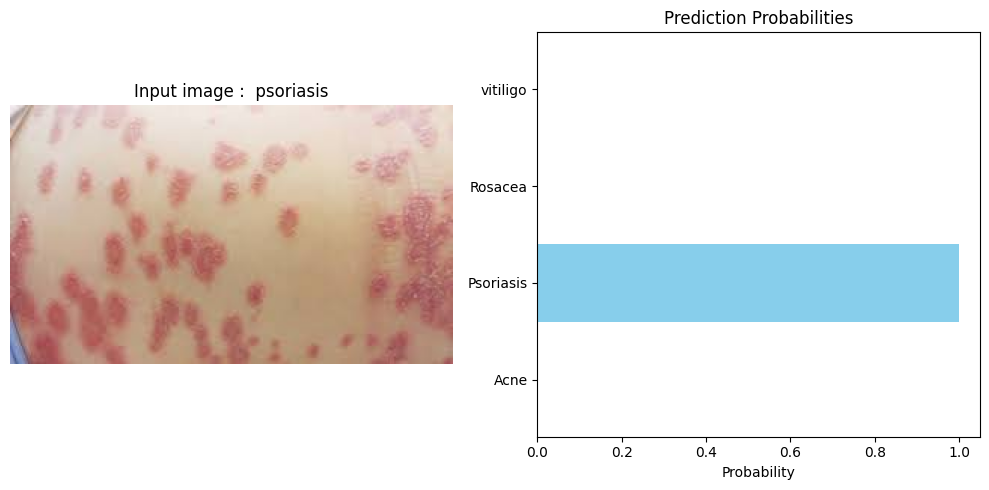

In [ ]:
# 2. 테스트 이미지 불러오기
image_path = "./Resnet50_pytorch/psoriasis_test_img2.jpg"  # 테스트 이미지 경로
image = Image.open(image_path)
image_class_name = 'psoriasis'

# 이미지 전처리
input_tensor = transform(image).unsqueeze(0).to(device)

# 3. 예측 수행
output = model(input_tensor)
probabilities = torch.nn.functional.softmax(output[0], dim=0)
class_idx = torch.argmax(probabilities).item()

# 클래스 이름 가져오기
class_names = state_dict['class_names']  # 클래스 이름은 ImageFolder에서 자동으로 불러옴
predicted_class = class_names[class_idx]

# 4. 결과 출력
print(f"예측된 질병: {predicted_class}")

# 5. 시각화
plt.figure(figsize=(10, 5))

# 1) 입력 이미지 시각화
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis("off")
plt.title(f"Input image :  {image_class_name}")

# 2) 클래스별 확률 시각화
plt.subplot(1, 2, 2)
plt.barh(class_names, probabilities.cpu().detach().numpy(), color='skyblue')
plt.xlabel("Probability")
plt.title("Prediction Probabilities")
plt.tight_layout()
plt.show()

예측된 질병: vitiligo


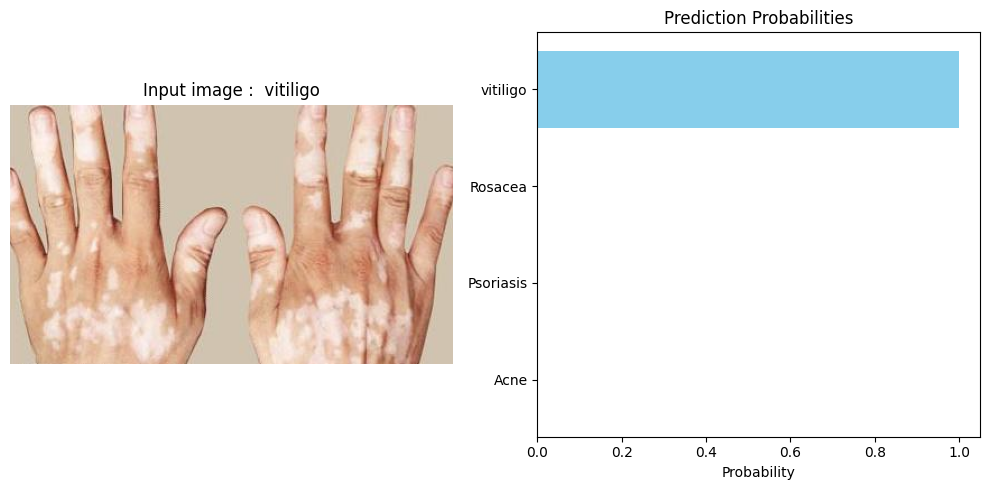

In [ ]:
# 2. 테스트 이미지 불러오기
image_path = "./Resnet50_pytorch/vitiligo_test_img.jpg"  # 테스트 이미지 경로
image = Image.open(image_path)
image_class_name = 'vitiligo'

# 이미지 전처리
input_tensor = transform(image).unsqueeze(0).to(device)

# 3. 예측 수행
output = model(input_tensor)
probabilities = torch.nn.functional.softmax(output[0], dim=0)
class_idx = torch.argmax(probabilities).item()

# 클래스 이름 가져오기
class_names = state_dict['class_names']  # 클래스 이름은 ImageFolder에서 자동으로 불러옴
predicted_class = class_names[class_idx]

# 4. 결과 출력
print(f"예측된 질병: {predicted_class}")

# 5. 시각화
plt.figure(figsize=(10, 5))

# 1) 입력 이미지 시각화
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis("off")
plt.title(f"Input image :  {image_class_name}")

# 2) 클래스별 확률 시각화
plt.subplot(1, 2, 2)
plt.barh(class_names, probabilities.cpu().detach().numpy(), color='skyblue')
plt.xlabel("Probability")
plt.title("Prediction Probabilities")
plt.tight_layout()
plt.show()